## Import libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2025-03-02 01:35:08.163444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740872108.180670    9724 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740872108.186213    9724 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 01:35:08.204181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Get data paths

In [2]:
DATA_PATH = "./MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"

### Load train and validation csv files

In [3]:
trainDF = pd.read_csv(TRAIN_PATH, names=['Path', 'Label'], header=None)
validDF = pd.read_csv(VALID_PATH, names=['Path', 'Label'], header=None)

### Display first rows for train csv

In [4]:
trainDF.head()

,Path,Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


### Display first rows for validation csv

In [5]:
validDF.head()

,Path,Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


### Display train studies count

In [6]:
len(trainDF)

13457

### Display validation studies count

In [7]:
len(validDF)

1199

### Histogram for train studies 

array([[<AxesSubplot: title={'center': 'Label'}>]], dtype=object)

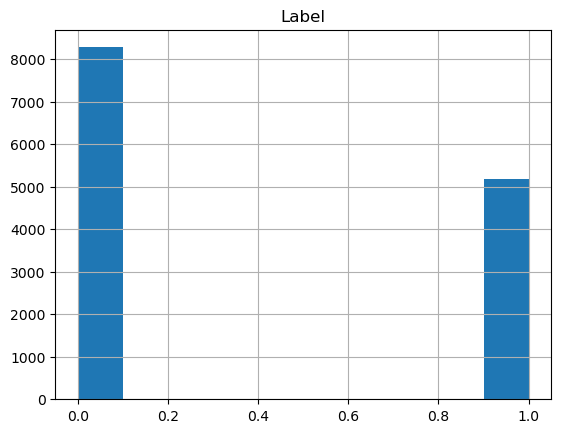

In [8]:
trainDF.hist()

### Histogram for validation studies 

array([[<AxesSubplot: title={'center': 'Label'}>]], dtype=object)

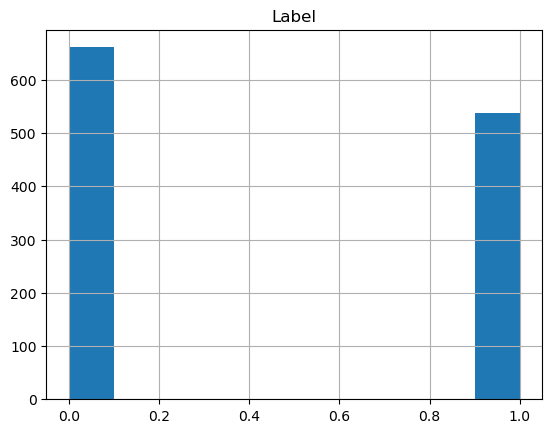

In [9]:
validDF.hist()

### Display count for (0,1) labels for train data
**normal:0, abnormal:1**

In [10]:
trainDF["Label"].value_counts()

Label
0    8280
1    5177
Name: count, dtype: int64

### Display count for (0,1) labels for validation data
**Normal (0), Abnormal (1)**

In [11]:
validDF["Label"].value_counts()

Label
0    661
1    538
Name: count, dtype: int64

### Method for Loading Image Paths with Labels

- **Each study contains one or more medical images.**  
- **Each study is labeled as either Normal (0) or Abnormal (1).**  
- **Load the file paths of all images associated with each study.**  
- **Assign the same label to all images based on their parent study's classification.**  
- **Return two NumPy arrays: one containing image paths and the other containing their corresponding labels.**  


In [12]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "./"  # Root dataset directory
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        for image_file in os.listdir(study_path):
            image_path = os.path.join(study_path, image_file)
            if image_path.endswith(".png") and not image_file.startswith("._"):
                image_paths.append(image_path)
                labels.append(label)
    return np.array(image_paths), np.array(labels)

### Load data
**Load train, validation image paths with corresponding labels using load_data method**

In [13]:
train_images_path, train_labels = load_data(TRAIN_PATH)
valid_images_path, valid_labels = load_data(VALID_PATH)

### Display images count for train data

In [14]:
len(train_images_path)

36808

### Display labels count for train data

In [15]:
len(train_labels)

36808

### Display images count for validation data

In [16]:
len(valid_images_path)

3197

### Display labels count for validation data

In [17]:
len(valid_labels)

3197

### Preparing the Training and Validation DataFrames

In this cell, two DataFrames, `trainDF` and `validDF`, are being created to hold the training and validation data respectively.
These DataFrames are used to structure the data, with each containing the image paths, labels, and corresponding body part extracted from the paths.

In [18]:
trainDF = pd.DataFrame(
    {'image_path': train_images_path, 'Label': train_labels}
)
trainDF['body_part'] = trainDF['image_path'].apply(lambda x: x.split('/')[3])

validDF = pd.DataFrame(
    {'image_path': valid_images_path, 'Label': valid_labels}
)
validDF['body_part'] = validDF['image_path'].apply(lambda x: x.split('/')[3])


### Display the first rows for train DataFrame

In [19]:
trainDF.head()

,image_path,Label,body_part
0,./MURA-v1.1/train/XR_SHOULDER/patient00001/stu...,1,XR_SHOULDER
1,./MURA-v1.1/train/XR_SHOULDER/patient00001/stu...,1,XR_SHOULDER
2,./MURA-v1.1/train/XR_SHOULDER/patient00001/stu...,1,XR_SHOULDER
3,./MURA-v1.1/train/XR_SHOULDER/patient00002/stu...,1,XR_SHOULDER
4,./MURA-v1.1/train/XR_SHOULDER/patient00002/stu...,1,XR_SHOULDER


### Display the labels(0,1) count for train data

In [20]:
trainDF["Label"].value_counts()

Label
0    21935
1    14873
Name: count, dtype: int64

### Histogram for train data

<AxesSubplot: >

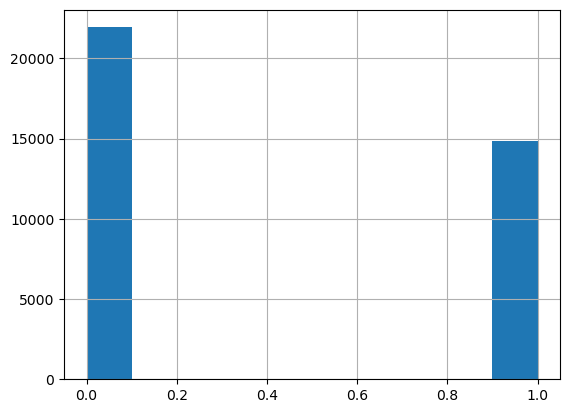

In [21]:
trainDF["Label"].hist()

### Display the labels(0,1) count for validation data

In [22]:
validDF["Label"].value_counts()

Label
0    1667
1    1530
Name: count, dtype: int64

### Histogram for validation data

<AxesSubplot: >

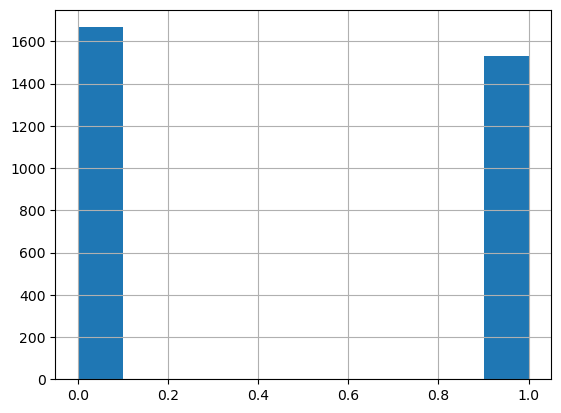

In [23]:
validDF['Label'].hist()

### Counts and visualizes the distribution of body parts in the training data of the MURA dataset.

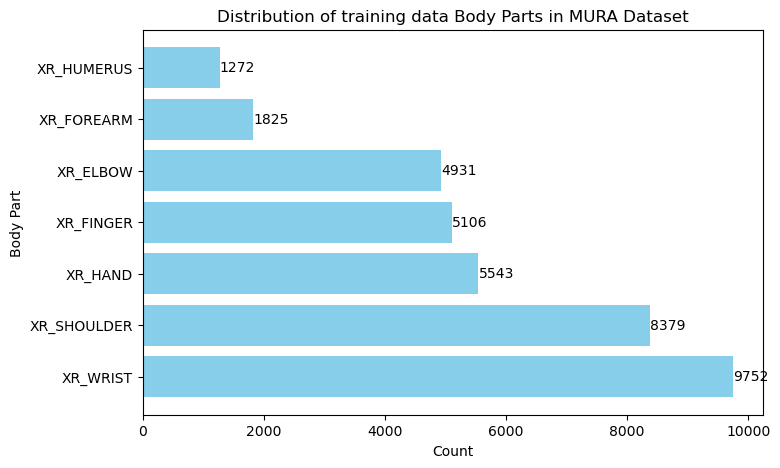

In [24]:
# Count occurrences of each body part
body_part_counts = trainDF['body_part'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(8, 5))
bars = plt.barh(body_part_counts.index, body_part_counts.values, color='skyblue')

# Add text labels to display exact counts
for bar, count in zip(bars, body_part_counts.values):
    plt.text(count + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')

# Labels and title
plt.xlabel("Count")
plt.ylabel("Body Part")
plt.title("Distribution of training data Body Parts in MURA Dataset")
plt.show()

### Counts and visualizes the distribution of body parts in the validation data of the MURA dataset.

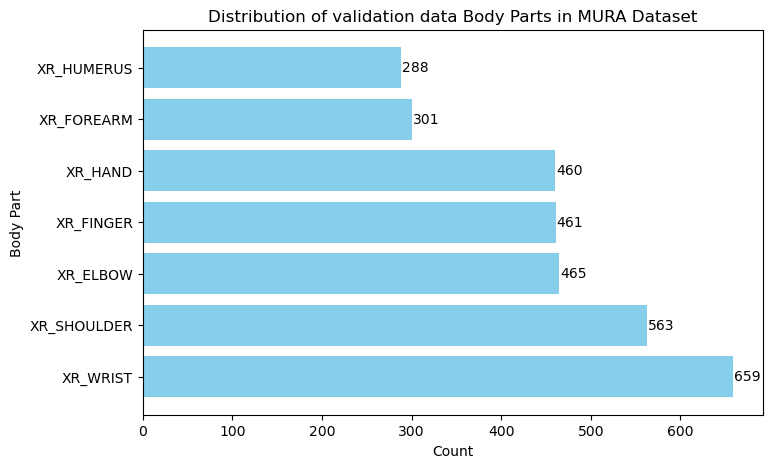

In [25]:
# Count occurrences of each body part
body_part_counts = validDF['body_part'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(8, 5))
bars = plt.barh(body_part_counts.index, body_part_counts.values, color='skyblue')

# Add text labels to display exact counts
for bar, count in zip(bars, body_part_counts.values):
    plt.text(count + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')

# Labels and title
plt.xlabel("Count")
plt.ylabel("Body Part")
plt.title("Distribution of validation data Body Parts in MURA Dataset")
plt.show()

### Counts and visualizes normal vs abnormal cases for each body part in the training data.

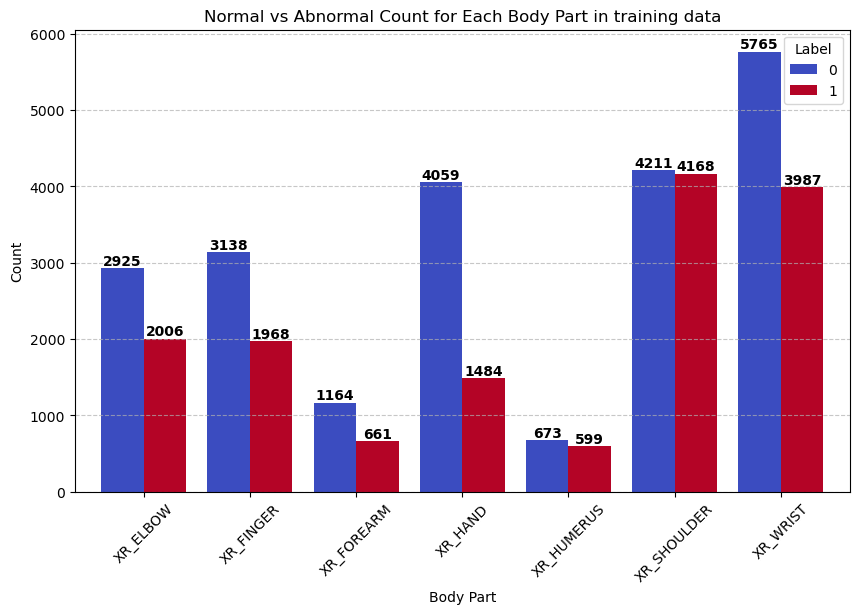

In [26]:
import matplotlib.pyplot as plt

# Count normal & abnormal cases for each body part
body_part_counts = trainDF.groupby(['body_part', 'Label']).size().unstack()

# Plot
ax = body_part_counts.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='coolwarm')

# Add text labels for exact counts
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel("Body Part")
plt.ylabel("Count")
plt.title("Normal vs Abnormal Count for Each Body Part in training data")
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Counts and visualizes normal vs abnormal cases for each body part in the validation data.

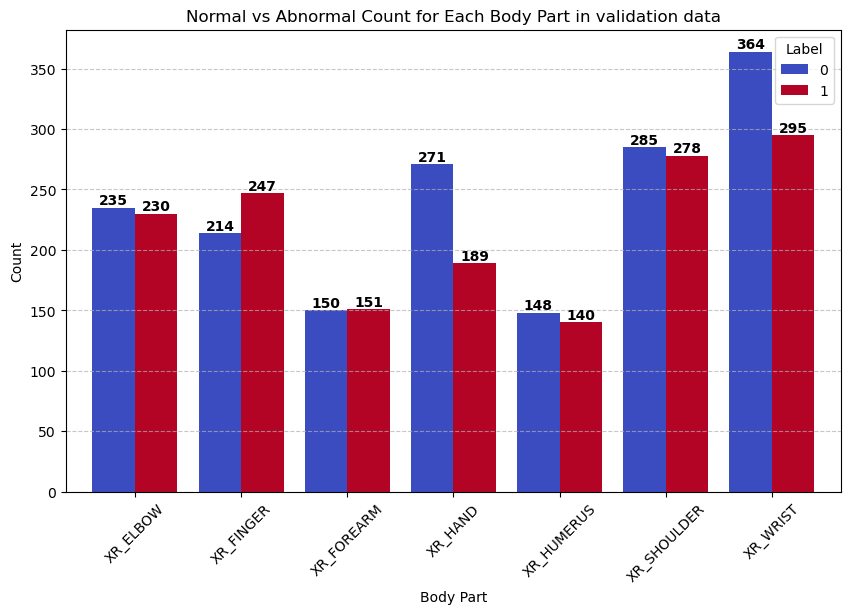

In [27]:
import matplotlib.pyplot as plt

# Count normal & abnormal cases for each body part
body_part_counts = validDF.groupby(['body_part', 'Label']).size().unstack()

# Plot
ax = body_part_counts.plot(kind='bar', figsize=(10, 6), width=0.8, colormap='coolwarm')

# Add text labels for exact counts
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Labels and title
plt.xlabel("Body Part")
plt.ylabel("Count")
plt.title("Normal vs Abnormal Count for Each Body Part in validation data")
plt.xticks(rotation=45)
plt.legend(title="Label")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Displays a heatmap of label distribution (normal vs abnormal) by body part in the training data.

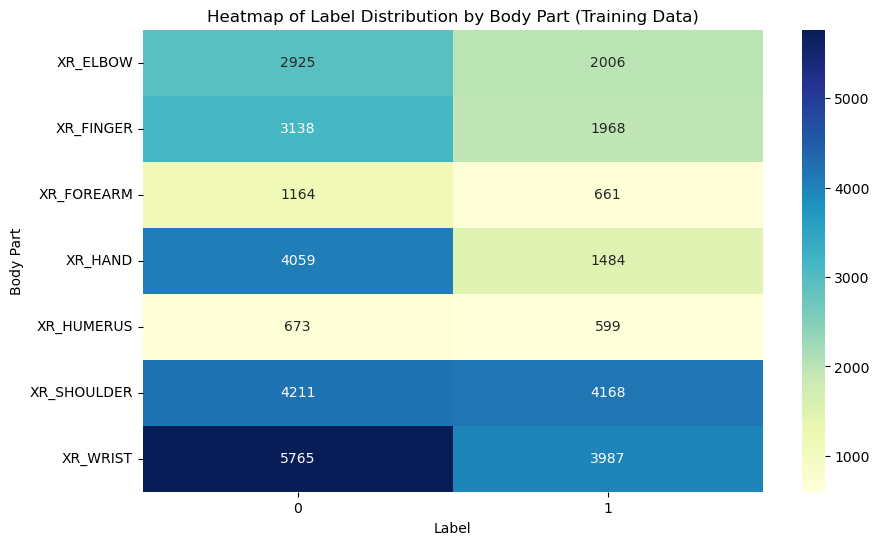

In [28]:
import seaborn as sns

pivot = trainDF.groupby(['body_part', 'Label']).size().unstack().fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Label Distribution by Body Part (Training Data)")
plt.xlabel("Label")
plt.ylabel("Body Part")
plt.show()


### Displays a heatmap of label distribution (normal vs abnormal) by body part in the validation data.

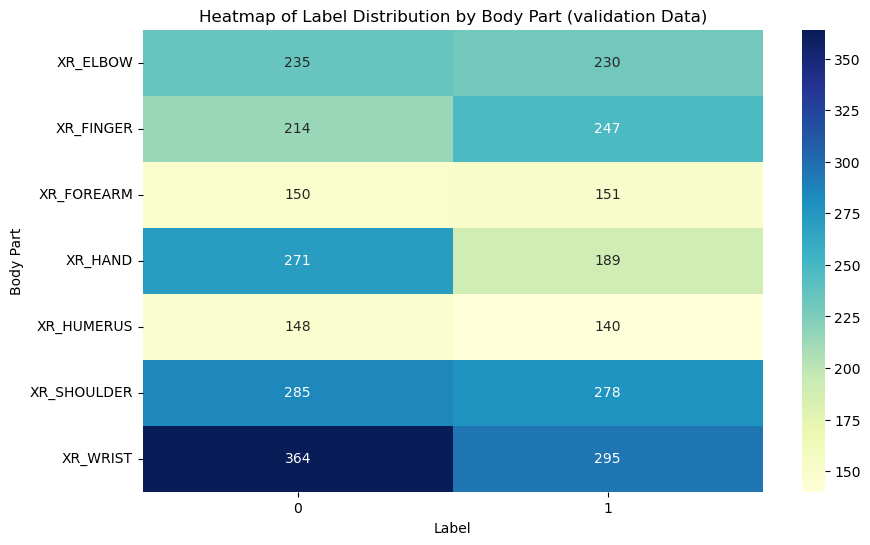

In [29]:
import seaborn as sns

pivot = validDF.groupby(['body_part', 'Label']).size().unstack().fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Label Distribution by Body Part (validation Data)")
plt.xlabel("Label")
plt.ylabel("Body Part")
plt.show()

### Randomly displays normal and abnormal X-ray images for each body part in the training data.

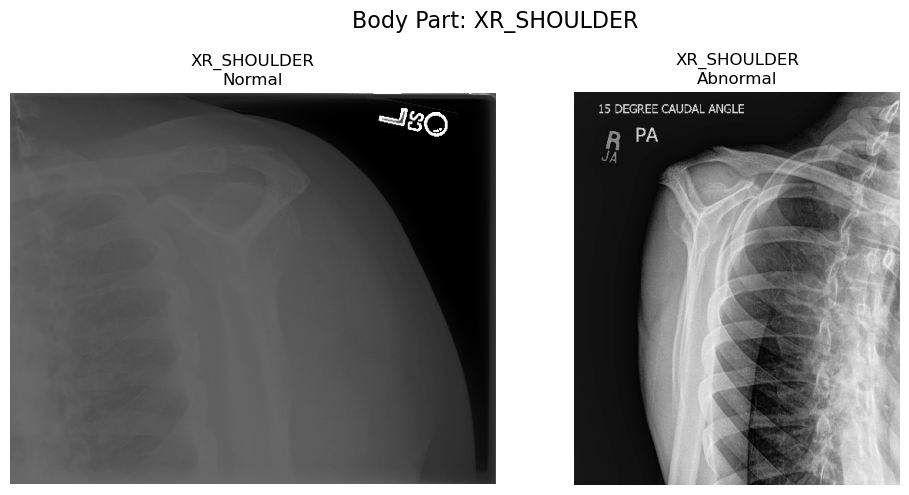

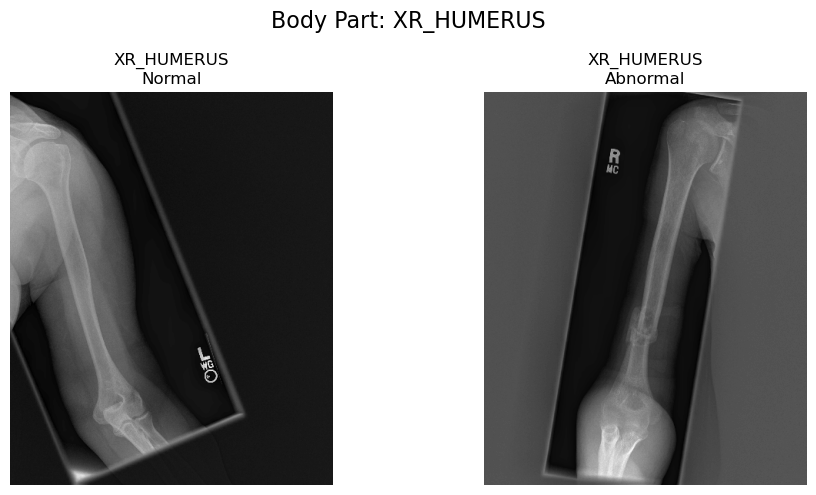

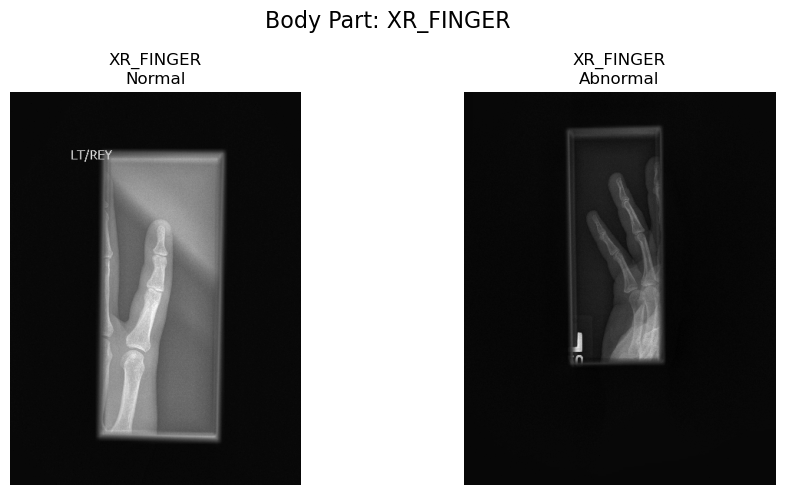

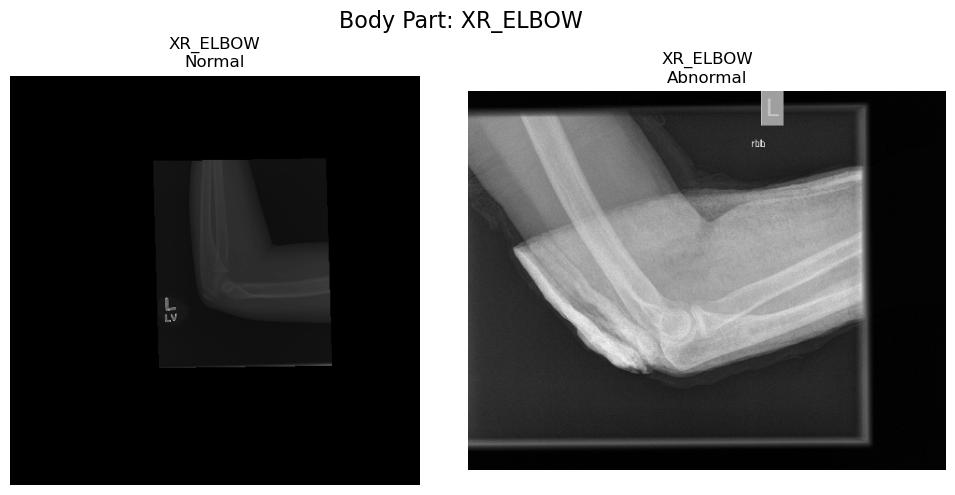

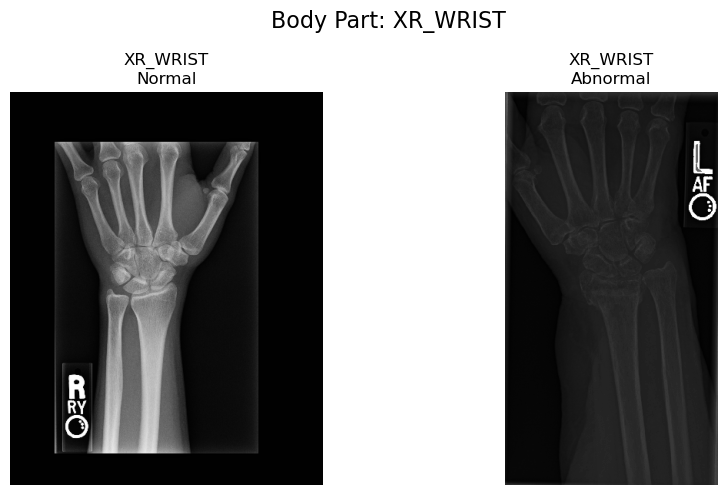

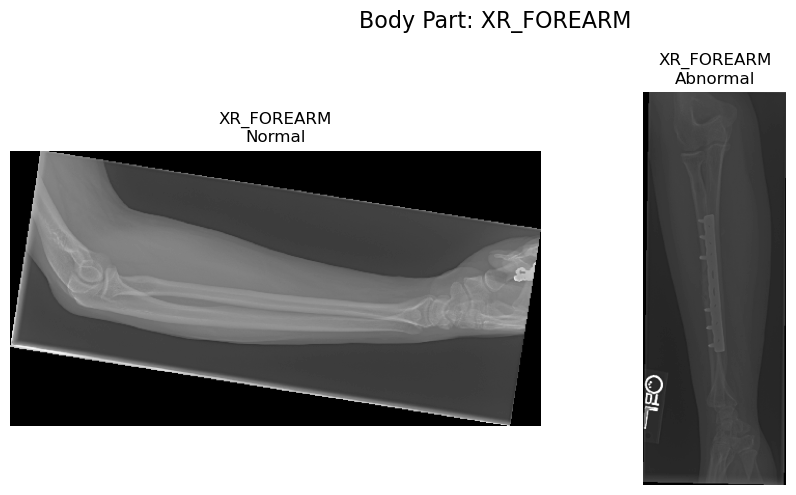

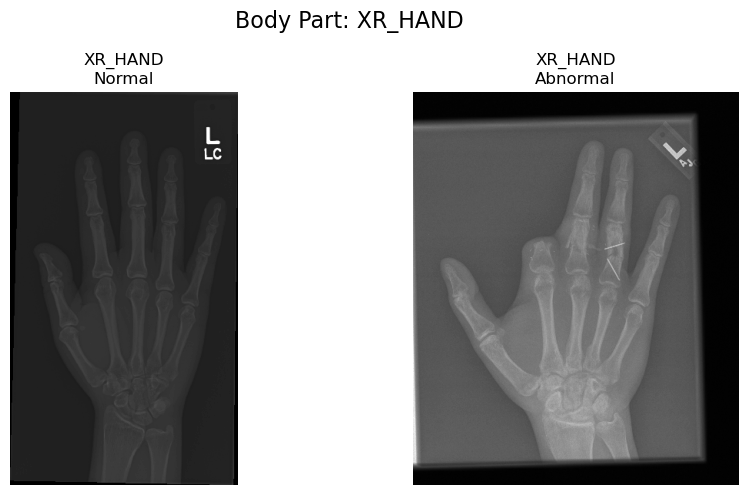

In [30]:
import matplotlib.pyplot as plt
import cv2
import random

# Assuming normal is represented by 0 and abnormal by 1.
label_map = {0: "normal", 1: "abnormal"}

# Get unique body parts
body_parts = trainDF['body_part'].unique()

for part in body_parts:
    # Filter the dataframe for the current body part
    part_df = trainDF[trainDF['body_part'] == part]
    
    # Check if there is at least one normal and one abnormal sample
    normal_samples = part_df[part_df['Label'] == 0]
    abnormal_samples = part_df[part_df['Label'] == 1]
    
    if normal_samples.empty or abnormal_samples.empty:
        print(f"Skipping {part} because one of the labels is missing.")
        continue

    # Randomly sample one image for each label
    normal_sample = normal_samples.sample(1).iloc[0]
    abnormal_sample = abnormal_samples.sample(1).iloc[0]

    # Create a figure with 2 subplots (horizontally)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Normal image
    img_normal = cv2.imread(normal_sample['image_path'], cv2.IMREAD_GRAYSCALE)
    axes[0].imshow(img_normal, cmap='gray')
    axes[0].set_title(f"{part}\nNormal")
    axes[0].axis('off')
    
    # Abnormal image
    img_abnormal = cv2.imread(abnormal_sample['image_path'], cv2.IMREAD_GRAYSCALE)
    axes[1].imshow(img_abnormal, cmap='gray')
    axes[1].set_title(f"{part}\nAbnormal")
    axes[1].axis('off')
    
    # Overall title for the figure
    plt.suptitle(f"Body Part: {part}", fontsize=16)
    plt.tight_layout()
    plt.show()


### Displays histograms of image width and height distributions for a random sample of 100 images in the training data.

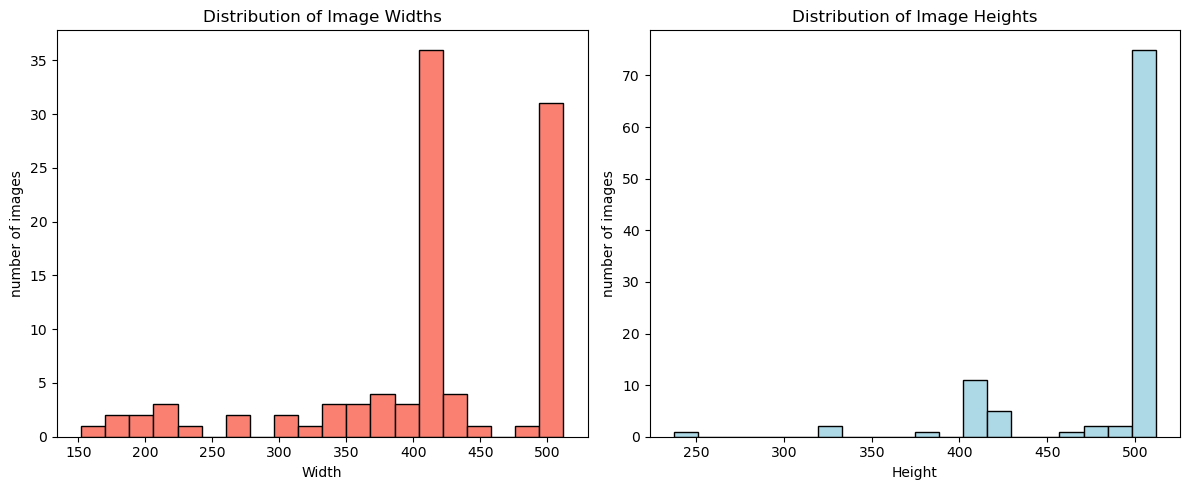

In [31]:
sample_paths = random.sample(list(trainDF['image_path']), 100)
widths, heights = [], []
for path in sample_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        h, w = img.shape
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.xlabel("Width")
plt.ylabel("number of images")
plt.title("Distribution of Image Widths")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='lightblue', edgecolor='black')
plt.xlabel("Height")
plt.ylabel("number of images")
plt.title("Distribution of Image Heights")
plt.tight_layout()
plt.show()
